![Inspire logo](images/inspire_logo.png "Inspire logo")

# Inspire | Summer 2021

# Handwritten number recognition

Using this notebook, we will train an artificial neural network (ANN) to recognise handwritten numbers like the ones below:


![Handwritten numbers](images/handwritten_numbers.png "Some examples of handwritten numbers")

# Part 1. Set up

## Get access to Python software packages

These are software packages that have already been installed on the computer. Here we import the packages so that we can use their functions in our code.

TensorFlow is a machine learning software package that is used for real-world applications by companies including eBay, snapchat and Airbus. We will use the Keras interface into TensorFlow to build and train our model.

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers

pd.set_option("max_columns", 28)

## Functions
These functions are used later on in the code. You do not need to read or understand these functions.

In [2]:
# A function to load the dataset of handwritten numbers

def load_data():
    """Load the dataset and split it into training, validation and test datasets."""
    validation_split = 0.1
    (x_train_val, y_train_val), (x_test, y_test) = mnist.load_data()
    x_train, x_val, y_train, y_val = train_test_split(
        x_train_val, y_train_val, test_size=validation_split, 
        stratify=y_train_val, random_state=7)
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [3]:
# Functions to display the handwritten numbers

def show_image(x, y, i):
    """Show image i from a dataset of samples, x, and labels, y."""
    plt.subplots(figsize=(10, 10))
    plt.imshow(x[i], cmap=plt.get_cmap("binary"))
    plt.title(f"A handwritten number {y[i]}")
    plt.grid(True)
    plt.xticks(ticks=range(28))
    plt.yticks(ticks=range(28));
    
    
def show__multi_images(x, y, i):
    """Show 25 images from a dataset of samples, x, and labels, y.
         Starting with image i."""
    n = 25
    assert i+n <= x.shape[0], f"i must be less than {x.shape[0]-n+1}."

    print(f"Data samples from {i} to {i+n-1}:")
    plt.subplots(figsize=(10, 10))
    for j in range(n):
        plt.subplot(5, 5, j+1)
        plt.imshow(x[i+j], cmap=plt.get_cmap("binary"))
        plt.title(f"Number {y[i+j]}")
        plt.xticks(ticks=[])
        plt.yticks(ticks=[])

In [4]:
# Functions to prepare the data for input to a model

def _scale_and_label_data(x_train, y_train, x_val, y_val, x_test, y_test):
    """Return the data rescaled and with one-hot encoded labels. """
    # Rescale the matrices of numbers so that they are 0 to 1 instead of 0 to 255.
    x_train = x_train.astype("float32") / 255
    x_val = x_val.astype("float32") / 255
    x_test = x_test.astype("float32") / 255

    # Convert each label from a number from 0 to 9 to a 1x10 vector of 0s and 1s
    num_classes = 10
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_val = keras.utils.to_categorical(y_val, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)
    

def _reshape_data_for_mlp(x_train, x_val, x_test):
    """Return the data reshaped for input to an MLP model. """
    # Reshape the datasets from (n, 28, 28) to (n, 784)
    x_train = np.reshape(x_train, (x_train.shape[0], 28*28))
    x_val = np.reshape(x_val, (x_val.shape[0], 28*28))
    x_test = np.reshape(x_test, (x_test.shape[0], 28*28))
    return x_train, x_val, x_test


def prepare_data(x_train, y_train, x_val, y_val, x_test, y_test):
    """Return the data rescaled and reshaped ready for input to an MLP model. """
    # Rescale the matrices of numbers so that they are 0 to 1 instead of 0 to 255.
    # Convert each label from a number from 0 to 9 to a 1x10 vector of 0s and 1s
    (x_train, y_train), (x_val, y_val), (x_test, y_test) = _scale_and_label_data(
        x_train, y_train, x_val, y_val, x_test, y_test)

    # Reshape the matrices from (n, 28, 28) to (n, 784)
    x_train, x_val, x_test = _reshape_data_for_mlp(x_train, x_val, x_test)
    
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [19]:
# Functions regarding the model training

def duration(start):
    """Print the time elapsed since start time. """
    end = time.time()
    print('\nTraining complete in', round(end-start), 'seconds')

    
def plot_accuracy(hist):
    """Plot the metrics that were recorded in the log during model training. """
    log = pd.DataFrame(hist.history) 
    ax = log[["acc", "val_acc"]].plot(title='Training', grid=True, figsize=(10, 10))
    ax.set_xlabel("Model training iteration")

In [20]:
# Functions for using the trained model.

def identify(model, x_single):
    """Use the model to identify the number in a single data sample. """
    assert x_single.shape == (28*28, ), "Expected a 784x1 vector. Input a single, vectorised data sample."
    x_input = np.reshape(x_single, (1, 28*28))
    y_pred = model.predict(x_input)
    pred = np.argmax(y_pred, axis=1)[0]
    return pred


def reshape_and_show_image(x_single):
    """Reshape the data back into a matrix and show the image. """
    assert x_single.shape == (28*28, ), "Expected a 784x1 vector. Input a single, vectorised data sample."
    x_matrix = np.reshape(x_single, (1, 28, 28))
    plt.imshow(x_matrix[0], cmap=plt.get_cmap("binary"));
    
    
def get_label(y_single):
    """ Return the label from the input one-hot encoded category vector. """
    assert y_single.shape == (10, ), "Expected a 10x1 vector. Input a single, one-hot encoded category vector."
    return np.argmax(y_single)


def show_an_incorrectly_identified_sample(model, x, y):
    """Find and show the first sample that the model incorrectly identifies. """
    for i in range(x.shape[0]):
        model_output = identify(model, x[i])
        true_label = get_label(y[i])
        if model_output != true_label:
            reshape_and_show_image(x[i])
            print("Data sample", i, "is incorrectly identified.")
            print("The model identifies this data sample as the number:\t", model_output)
            print("The true label on this data sample is:\t\t\t", true_label)
            return i
    print("The model correctly identified all of the samples in this dataset")
    return -1

# Part 2. The input data
## Load the data
Load the images of the handwritten numbers. 

This is the dataset that we will use to train and test our machine learning model. The dataset contains thousands data samples. Each data sample is a different handwritten number between zero and nine. Each data sample has a label, which tells us what that handwritten number is supposed to be. The label is an integer (whole number) between 0 and 9.


Load data samples, x, and their labels, y. The dataset is split into datasets that will be used for different stages of model development:
+ training the model: x_train, y_train
+ validation (testing the model during model development): x_val, y_val
+ testing - a final test once model development is complete: x_test, y_test

In [21]:
# x is data samples, y is their labels. 
# val is short for validation.
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_data()

In [22]:
print(f"There are {x_train.shape[0]} samples and {y_train.shape[0]} labels in the training dataset.")
print(f"Each data sample in the training dataset is an image that is {x_train.shape[1]} pixels by {x_train.shape[2]} pixels.")
print(f"There are {x_val.shape[0]} samples and labels in the validation dataset.")
print(f"There are {x_test.shape[0]} samples and labels in the test dataset.")

There are 54000 samples and 54000 labels in the training dataset.
Each data sample in the training dataset is an image that is 28 pixels by 28 pixels.
There are 6000 samples and labels in the validation dataset.
There are 10000 samples and labels in the test dataset.


## View the data
Let's have a look at some of the images in the training dataset.

+ Are there any numbers you as a human would struggle to recognise with 100% accuracy? 
+ Can you see any patterns certain numbers have?

Data samples from 0 to 24:


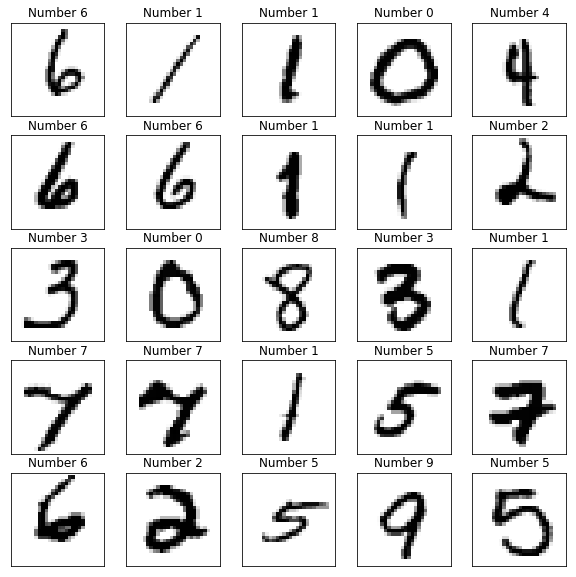

In [23]:
i_start = 0  # INSPIRE: change the number to an integer (whole number) 0 to 53975 to see different samples
show__multi_images(x_train, y_train, i_start)

## View a single data sample
Let's have a closer look at one of the images.

Each image is 28 pixels by 28 pixels. Each pixel is a tiny square of colour. Can you see how the two axes of the plot go from 0 to 27, to display each pixel?

There are 784 pixels in each image (28 x 28 = 784).

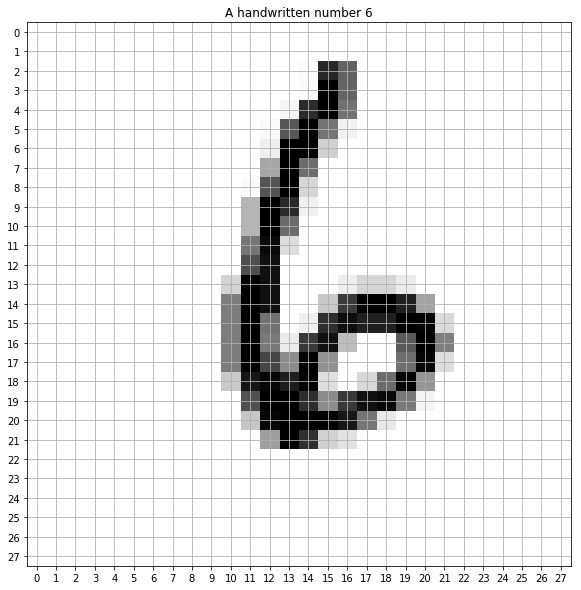

In [24]:
i = 0  # INSPIRE: change the number to an integer (whole number) 0 to 53999 to see a different sample
show_image(x_train, y_train, i)

## Display the raw data
We used some code to display the data sample above as an image. The data that we loaded is actually matrices of numbers. Each pixel is a number and this number tells the computer what colour the pixel should be. Let's have a look at this raw data.

Each handwritten number is stored as a 28x28 matrix of numbers from 0 to 255. The numbers 0 to 255 represent a grey colour-scale: 0 is white, 255 is black and numbers in between are greys.

Below is the matrix for one data sample (one handwritten number). 

+ Can you see where some columns are all white? 
+ Are there any columns that are all black? 
+ Can you see what number has been handwritten just by looking at this matrix?
+ Why is the image converted into numbers? 
+ Why do you think 0-255 is used for each pixel?

In [25]:
i = 0  # INSPIRE: change this number to show a different data sample
print(f"The raw data of sample {i}. Handwritten number {y_train[i]}:")
df = pd.DataFrame(x_train[i])
df

The raw data of sample 0. Handwritten number 6:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,215,156,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,254,155,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,9,212,254,140,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,6,168,254,139,14,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,16,254,252,48,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,89,254,146,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,5,171,254,41,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,74,254,213,15,0,0,0,0,0,0,0,0,0,0,0,0,0


# Part 3. Build and train a machine learning model

## Prepare the data
This changes the data to the size and scale that the model requires.

In [26]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = prepare_data(
    x_train, y_train, x_val, y_val, x_test, y_test)

## Build the model
Here we build an artificial neural network (ANN) model, just as we saw in the "What is a neural network?" presentation.

TODO provide an activity sheet to guide the students through changing the model to improve its accuracy.

In [27]:
# Set the size of the input layer and the output layer.
num_input_nodes = 784  # Each image has 784 pixels (28 x 28): this is the input data size.
num_output_nodes = 10  # Ten output nodes for the ten possible outputs: 0, 1, 2, 3,...,9

In [28]:
# Set the size of the hidden layers
model = keras.Sequential(
    [
        # Input layer
        keras.Input(shape=num_input_nodes),
        # Hidden layers
        layers.Dense(4, activation='relu'),  # INSPIRE: change the number of nodes in this layer
        layers.Dense(2, activation='relu'),  # INSPIRE: change the number of nodes in this layer
        # INSPIRE: add one or more hidden layers before the output layer
        # Output layer
        layers.Dense(num_output_nodes, activation="softmax", name="final_layer"), 
    ]
)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Set the training parameters
batch_size = 128  # INSPIRE: change the number of data samples that will be input to the model in each training step
iterations = 5  # INSPIRE: change the number of training iterations

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4)                 3140      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 10        
_________________________________________________________________
final_layer (Dense)          (None, 10)                30        
Total params: 3,180
Trainable params: 3,180
Non-trainable params: 0
_________________________________________________________________


Before we train the model, let's look at some of the model's trainable parameters. Here we show two trainable parameters from the second layer of the model.

In [30]:
trainable_parameters_before_training, __ = model.layers[1].get_weights()
trainable_parameters_before_training[0][:2]

array([-0.08019304,  0.35674548], dtype=float32)

## Train the model
Here we train the artificial neural network (ANN) model.

In [31]:
start = time.time()
history = model.fit(x_train, y_train, batch_size=batch_size, 
              epochs=iterations, validation_data=(x_val, y_val))
duration(start)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 2s 28us/sample - loss: 1.7151 - acc: 0.3253 - val_loss: 1.4606 - val_acc: 0.4093
Epoch 2/5
54000/54000 [==============================] - 2s 28us/sample - loss: 1.3590 - acc: 0.4736 - val_loss: 1.2852 - val_acc: 0.5438
Epoch 3/5
54000/54000 [==============================] - 1s 26us/sample - loss: 1.2178 - acc: 0.6021 - val_loss: 1.1725 - val_acc: 0.6368
Epoch 4/5
54000/54000 [==============================] - 1s 27us/sample - loss: 1.1210 - acc: 0.6575 - val_loss: 1.0880 - val_acc: 0.6698
Epoch 5/5
54000/54000 [==============================] - 1s 27us/sample - loss: 1.0536 - acc: 0.6777 - val_loss: 1.0340 - val_acc: 0.6908

Training complete in 8 seconds


The accuracy of the model on the training and validation data was recorded during the training process. It is plotted below. We should see this increase with each model training iteration. The maximum value that accuracy can be is 1 (100% accuracy).

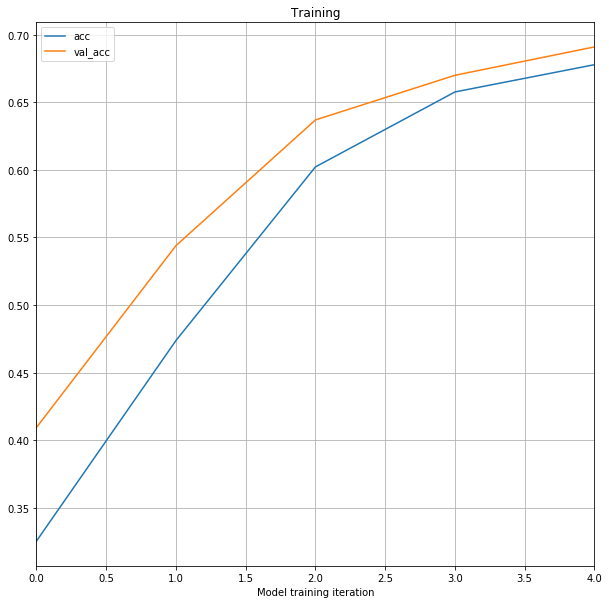

In [32]:
plot_accuracy(history)

## Validation accuracy 
How good is the trained model?

In [39]:
score = model.evaluate(x_val, y_val, verbose=0)
print("Testing using the validation dataset:")
print("Number of samples tested:", x_val.shape[0])
print("Accuracy:", score[1])

Testing using the validation dataset:
Number of samples tested: 6000
Accuracy: 0.69083333


## Trainable parameters
During model training the model's trainable parameters changed. Here we look at just two of those numbers, can you see how they have changed since before training?

In [34]:
trainable_parameters_before_training[0][:2]

array([-0.08019304,  0.35674548], dtype=float32)

In [35]:
trainable_parameters_after_training, __ = model.layers[1].get_weights()
trainable_parameters_after_training[0][:2]

array([-0.02704227,  0.78123766], dtype=float32)

## Using the model

The model identifies this as the number:	 0
The true label on this data sample is:		 0


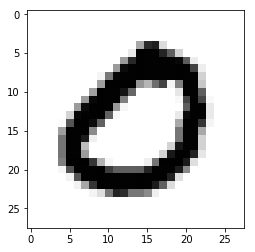

In [36]:
i = 3  # INSPIRE: change this number to try a different data sample

model_output = identify(model, x_val[i]) 
print("The model identifies this as the number:\t", model_output)

true_label = get_label(y_val[i])
reshape_and_show_image(x_val[i])
print("The true label on this data sample is:\t\t", true_label)

## When the model gets it wrong
Let's take a look at one of the images that the model fails to identify correctly. 

+ Would you have identified this number correctly?
+ Why do you think the model got this one wrong?
+ What jobs might a handwriting recognition model be used for? 
+ What would be the consequences of the model incorrectly identifying this number?

Data sample 4 is incorrectly identified.
The model identifies this data sample as the number:	 8
The true label on this data sample is:			 3


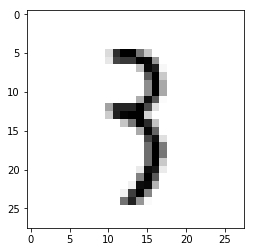

In [37]:
show_an_incorrectly_identified_sample(model, x_val, y_val);

# Part 4. Final test: How good is the finished model?
The test dataset (x_test, y_test) was not used during model development. The model has never "seen" the images in x_test. When you have finished making changes to the model and are completely happy with it, you can use the test dataset to do a final test. The model is evaluated by calculating how accurate it is at identifying handwritten numbers that it has not "seen" before.

The code cell below tests the model that you built and trained in the code above.

In [38]:
do_final_test = False  # INSPIRE: when model development is complete, change this to True

if do_final_test:
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Testing using the test dataset:")
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])

# Credits
http://yann.lecun.com/exdb/mnist/